<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course



# <center>Topic 7. Unsupervised learning: PCA and clustering

Welcome to the seventh part of our Open Machine Learning Course!  
  
In this lesson, we will work with unsupervised learning methods such as Principal Component Analysis (PCA) and clustering. You will learn why and how we can reduce the dimensionality of the original data and what the main approaches are for grouping similar data points.  


### Article outline
1. [Introduction](#1.-Introduction)
2. [PCA](#2.-Principal-Component-Analysis-(PCA))
 - [Intuition, theories, and application issues](#Intuition,-theories,-and-application-issues)
 - [Examples](#Examples)
3. [Clustering](#2.-Clustering)
 - [K-means](#K-means)
 - [Affinity Propagation](#Affinity-Propagation)
 - [Spectral clustering](#Spectral-clustering)
 - [Agglomerative clustering](#Agglomerative-clustering)
 - [Accuracy metrics](#Accuracy-metrics)
4. [Demo assignment](#4.-Demo-assignment)
5. [Useful resources](#5.-Useful-resources)

## 1. Introduction

The main feature of unsupervised learning algorithms, when compared to classification and regression methods, is that input data are unlabeled (i.e. no labels or classes given) and that the algorithm learns the structure of the data without any assistance. This creates two main differences. First, it allows us to process large amounts of data because the data does not need to be manually labeled. Second, it is difficult to evaluate the quality of an unsupervised algorithm due to the absence of an explicit goodness metric as used in supervised learning.  

One of the most common tasks in unsupervised learning is dimensionality reduction. On one hand, dimensionality reduction may help with data visualization (e.g. t-SNA method) while, on the other hand, it may help deal with the multicollinearity of your data and prepare the data for a supervised learning method (e.g. decision trees).


## 2. Principal Component Analysis (PCA)

### Intuition, theories, and application issues

Principal Component Analysis is one of the easiest, most intuitive, and most frequently used methods for dimensionality reduction, projecting data onto its orthogonal feature subspace.


<img align="right" src="https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png" width="400">


More generally speaking, all observations can be considered as an ellipsoid in a subspace of an initial feature space, and the new basis set in this subspace is aligned with the ellipsoid axes. This assumption lets us remove highly correlated features since basis set vectors are orthogonal. 
In the general case, the resulting ellipsoid dimensionality matches the initial space dimensionality, but the assumption that our data lies in a subspace with a smaller dimension allows us to cut off the "excessive" space with the new projection (subspace). We accomplish this in a 'greedy' fashion, sequentially selecting each of the ellipsoid axes by identifying where the dispersion is maximal.
 

> "To deal with hyper-planes in a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." - Geoffrey Hinton


Let's take a look at the mathematical formulation of this process:

In order to decrease the dimensionality of our data from $n$ to $k$ with $k \leq n$, we sort our list of axes in order of decreasing dispersion and take the top-$k$ of them.

We begin by computing the dispersion and the covariance of the initial features. This is usually done with the covariance matrix. According to the covariance definition, the covariance of two features is computed as follows: $$cov(X_i, X_j) = E[(X_i - \mu_i) (X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j,$$ where $\mu_i$ is the expected value of the $i$th feature. It is worth noting that the covariance is symmetric, and the covariance of a vector with itself is equal to its dispersion.

Therefore the covariance matrix is symmetric with the dispersion of the corresponding features on the diagonal. Non-diagonal values are the covariances of the corresponding pair of features. In terms of matrices where $\mathbf{X}$ is the matrix of observations, the covariance matrix is as follows:

$$\Sigma = E[(\mathbf{X} - E[\mathbf{X}]) (\mathbf{X} - E[\mathbf{X}])^{T}]$$

Quick recap: matrices, as linear operators, have eigenvalues and eigenvectors. They are very convenient because they describe parts of our space that do not rotate and only stretch when we apply linear operators on them; eigenvectors remain in the same direction but are stretched by a corresponding eigenvalue. Formally, a matrix $M$ with eigenvector $w_i$ and eigenvalue $\lambda_i$ satisfy this equation: $M w_i = \lambda_i w_i$.

The covariance matrix for a sample $\mathbf{X}$ can be written as a product of $\mathbf{X}^{T} \mathbf{X}$. According to the [Rayleigh quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient), the maximum variation of our sample lies along the eigenvector of this matrix and is consistent with the maximum eigenvalue. Therefore, the principal components we aim to retain from the data are just the eigenvectors corresponding to the top-$k$ largest eigenvalues of the matrix.

The next steps are easier to digest. We multiply the matrix of our data $X$ by these components to get the projection of our data onto the orthogonal basis of the chosen components. If the number of components was smaller than the initial space dimensionality, remember that we will lose some information upon applying this transformation.

## Examples
### Fisher's iris dataset

Let's start by uploading all of the essential modules and try out the iris example from the `scikit-learn` documentation. 

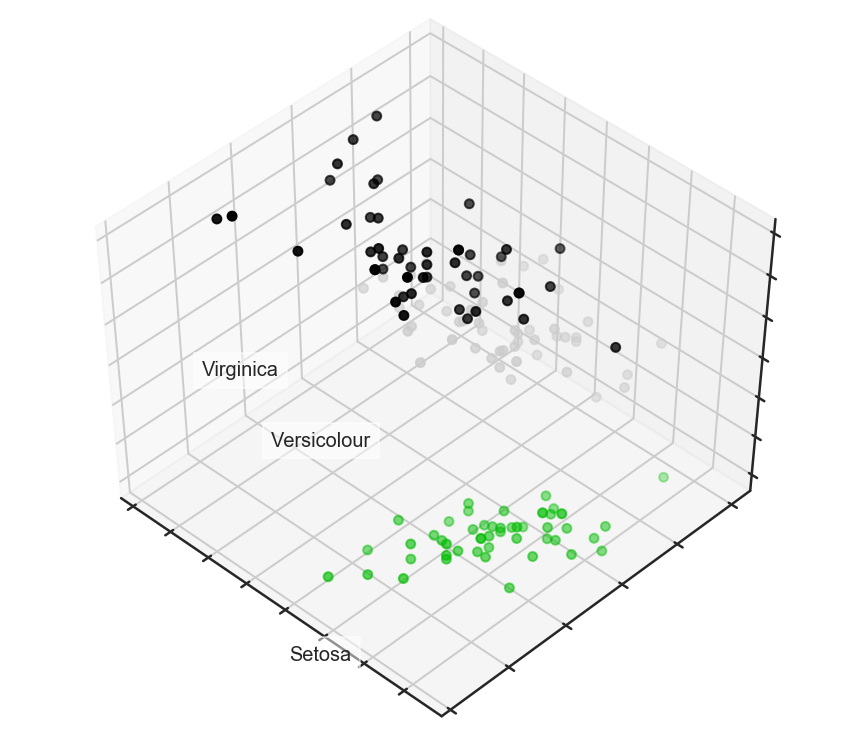

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

# Loading the dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Let's create a beautiful 3d-plot
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Change the order of labels, so that they match
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, 
           cmap=plt.cm.nipy_spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([]);

Now let's see how PCA will improve the results of a simple model that is not able to correctly fit all of the training data:

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Decision trees with depth = 2
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.88889


Let's try this again, but, this time, let's reduce the dimensionality to 2 dimensions:

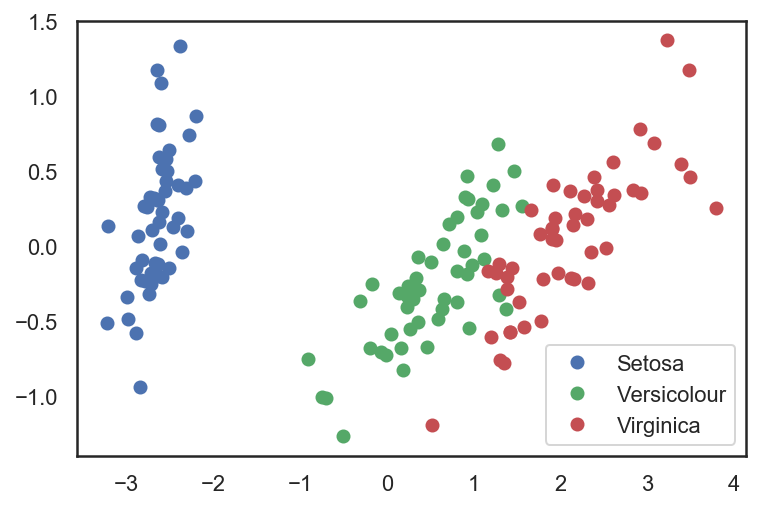

In [3]:
# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [4]:
# Test-train split and apply PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.91111


The accuracy did not increase significantly in this case, but, with other datasets with a high number of dimensions, PCA can drastically improve the accuracy of decision trees and other ensemble methods.

Now let's check out the percent of variance that can be explained by each of the selected components.

In [5]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### Handwritten numbers dataset 

Let's look at the handwritten numbers dataset that we used before in the [3rd lesson](https://habrahabr.ru/company/ods/blog/322534/#derevya-resheniy-i-metod-blizhayshih-sosedey-v-zadache-raspoznavaniya-rukopisnyh-cifr-mnist).

In [6]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

Let's start by visualizing our data. Fetch the first 10 numbers. The numbers are represented by 8 x 8 matrixes with the color intensity for each pixel. Every matrix is flattened into a vector of 64 numbers, so we get the feature version of the data.

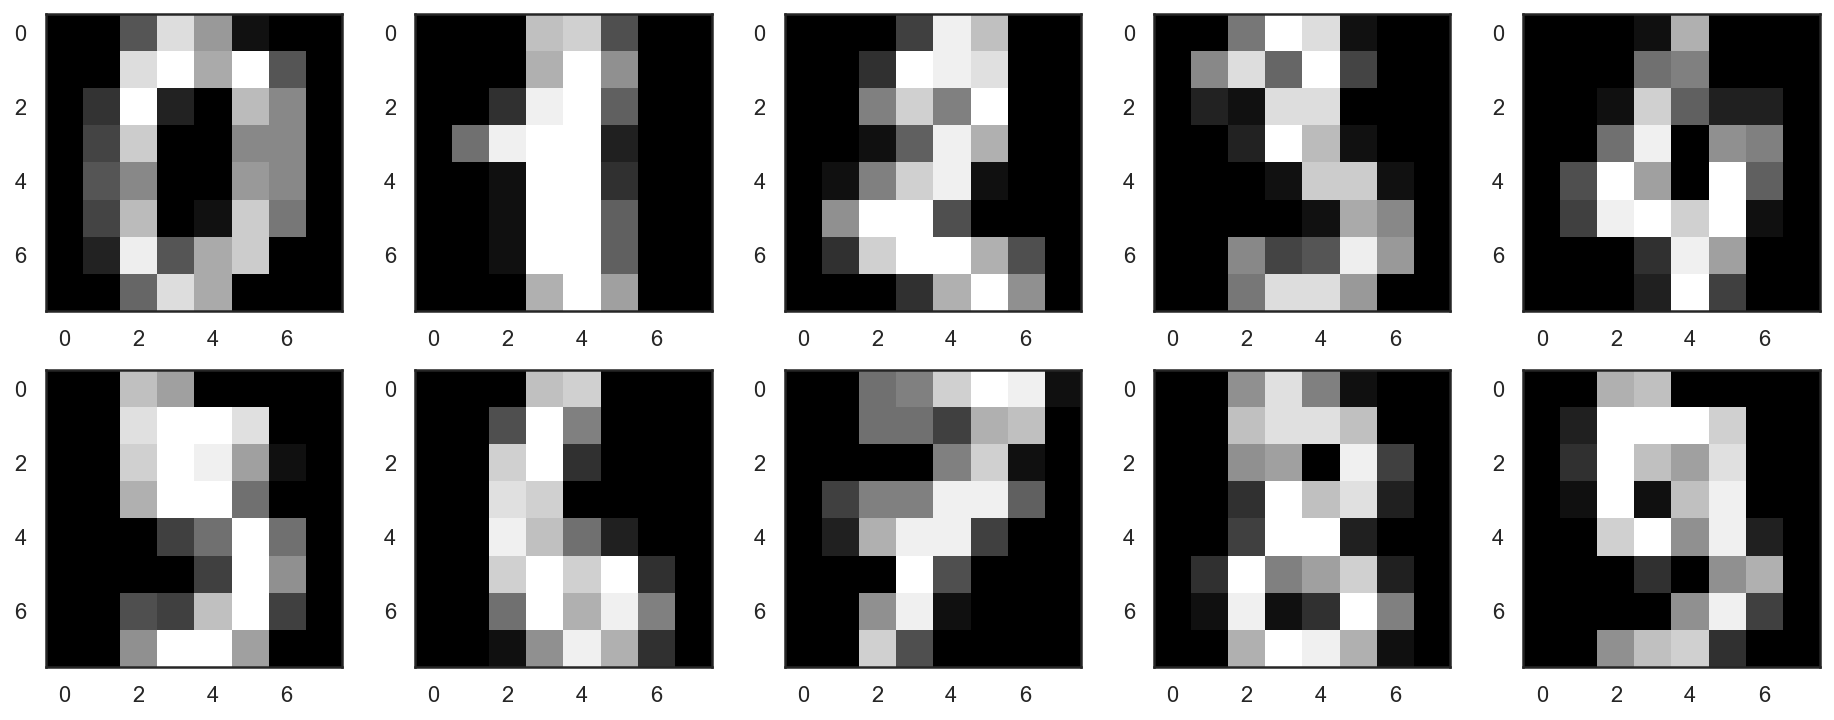

In [7]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

Our data has 64 dimensions, but we are going to reduce it to only 2 and see that, even with just 2 dimensions, we can clearly see that digits separate into clusters.

Projecting 64-dimensional data to 2D


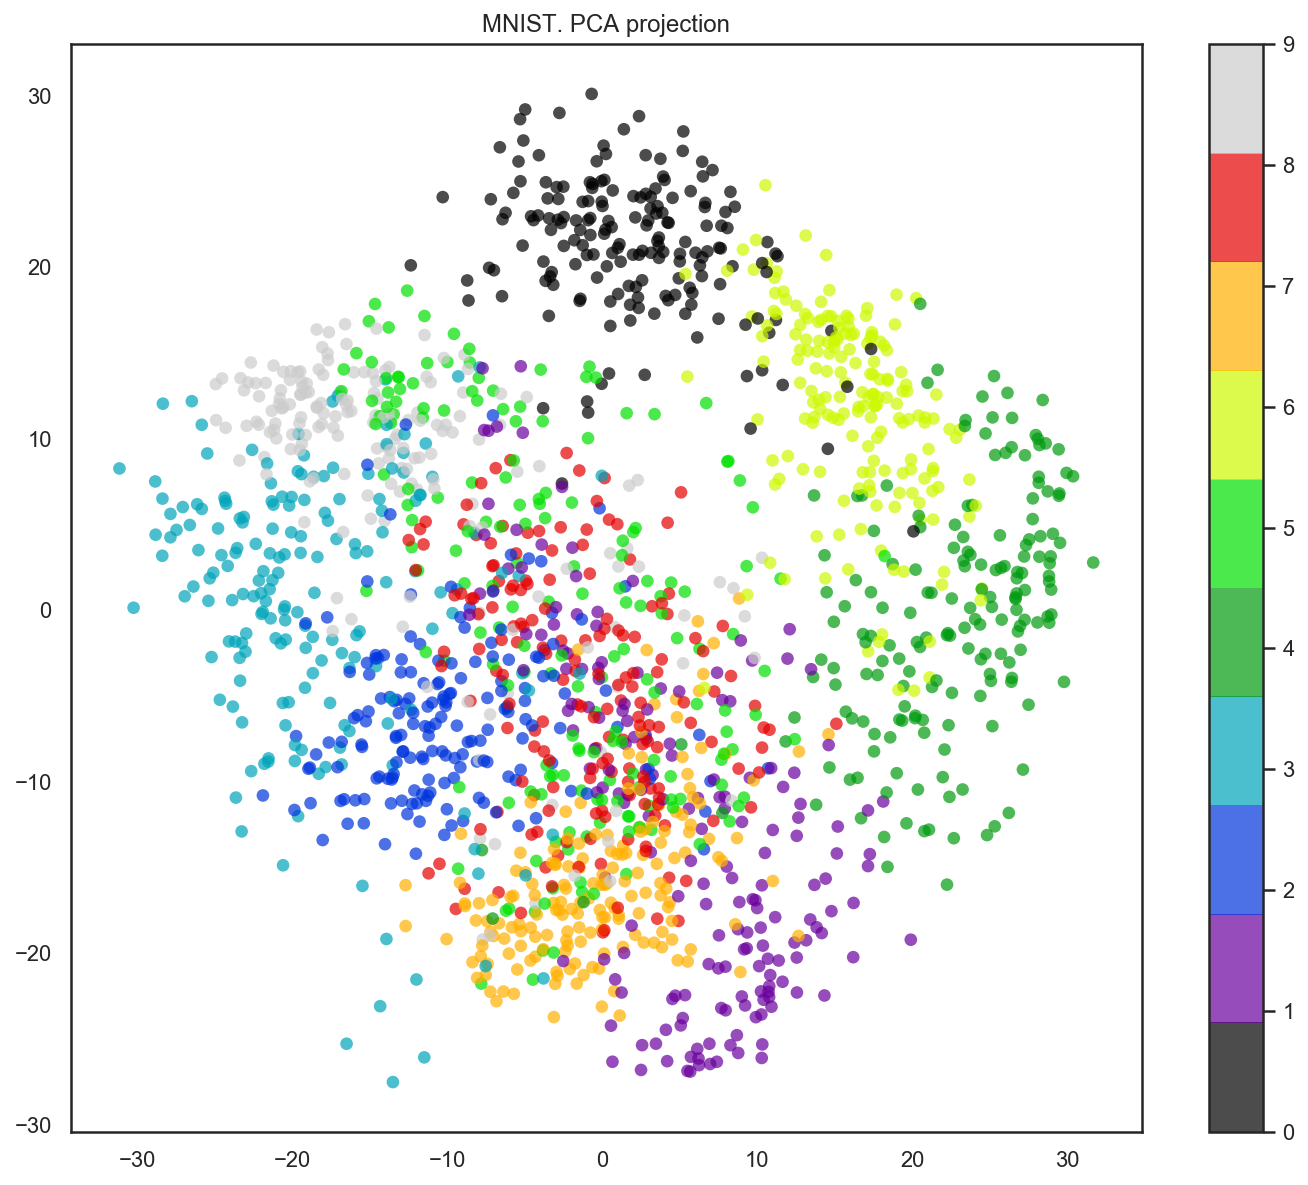

In [8]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

In practice, we would choose the number of principal components such that we can explain 90% of the initial data dispersion (via the `explained_variance_ratio`). Here, that means retaining 21 principal components; therefore, we reduce the dimensionality from 64 features to 21.

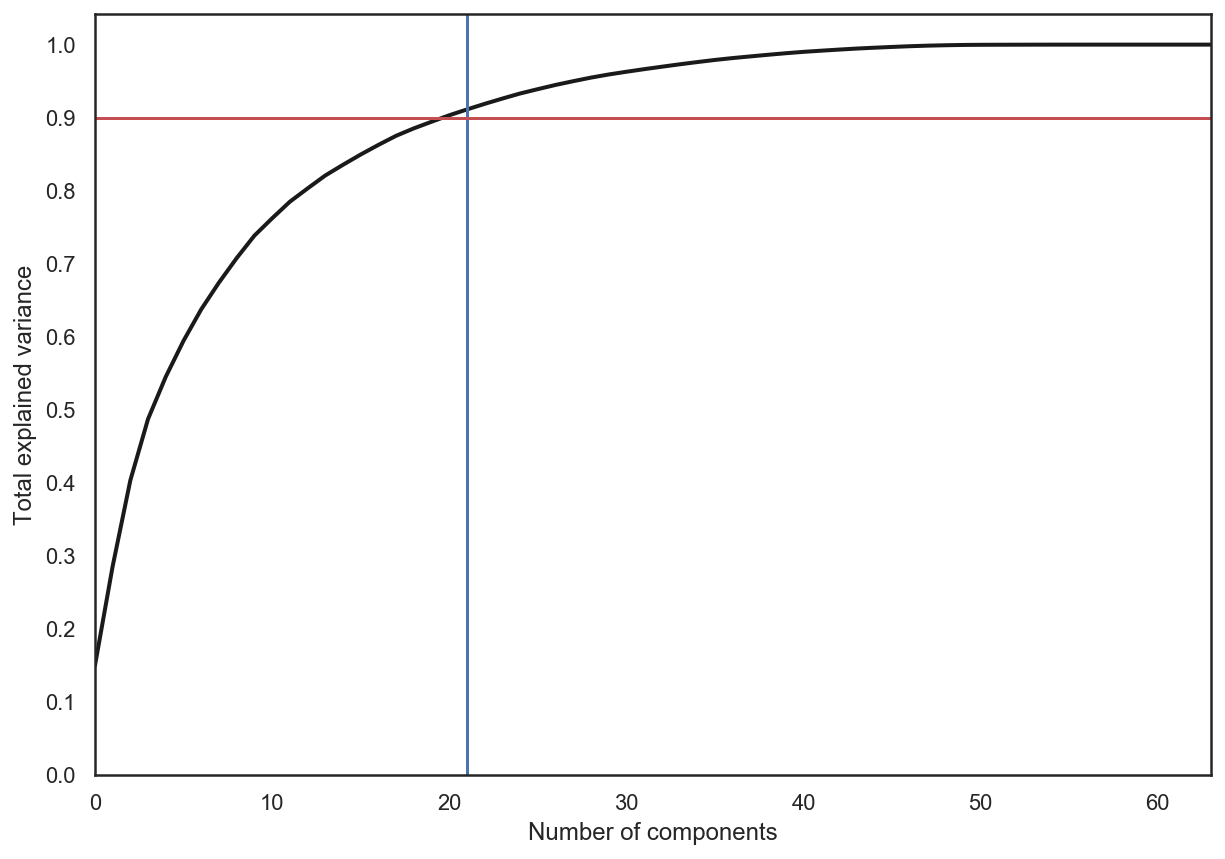

In [14]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

# LDA

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [10]:
X_LDA = LDA(n_components=2).fit_transform(X,y)

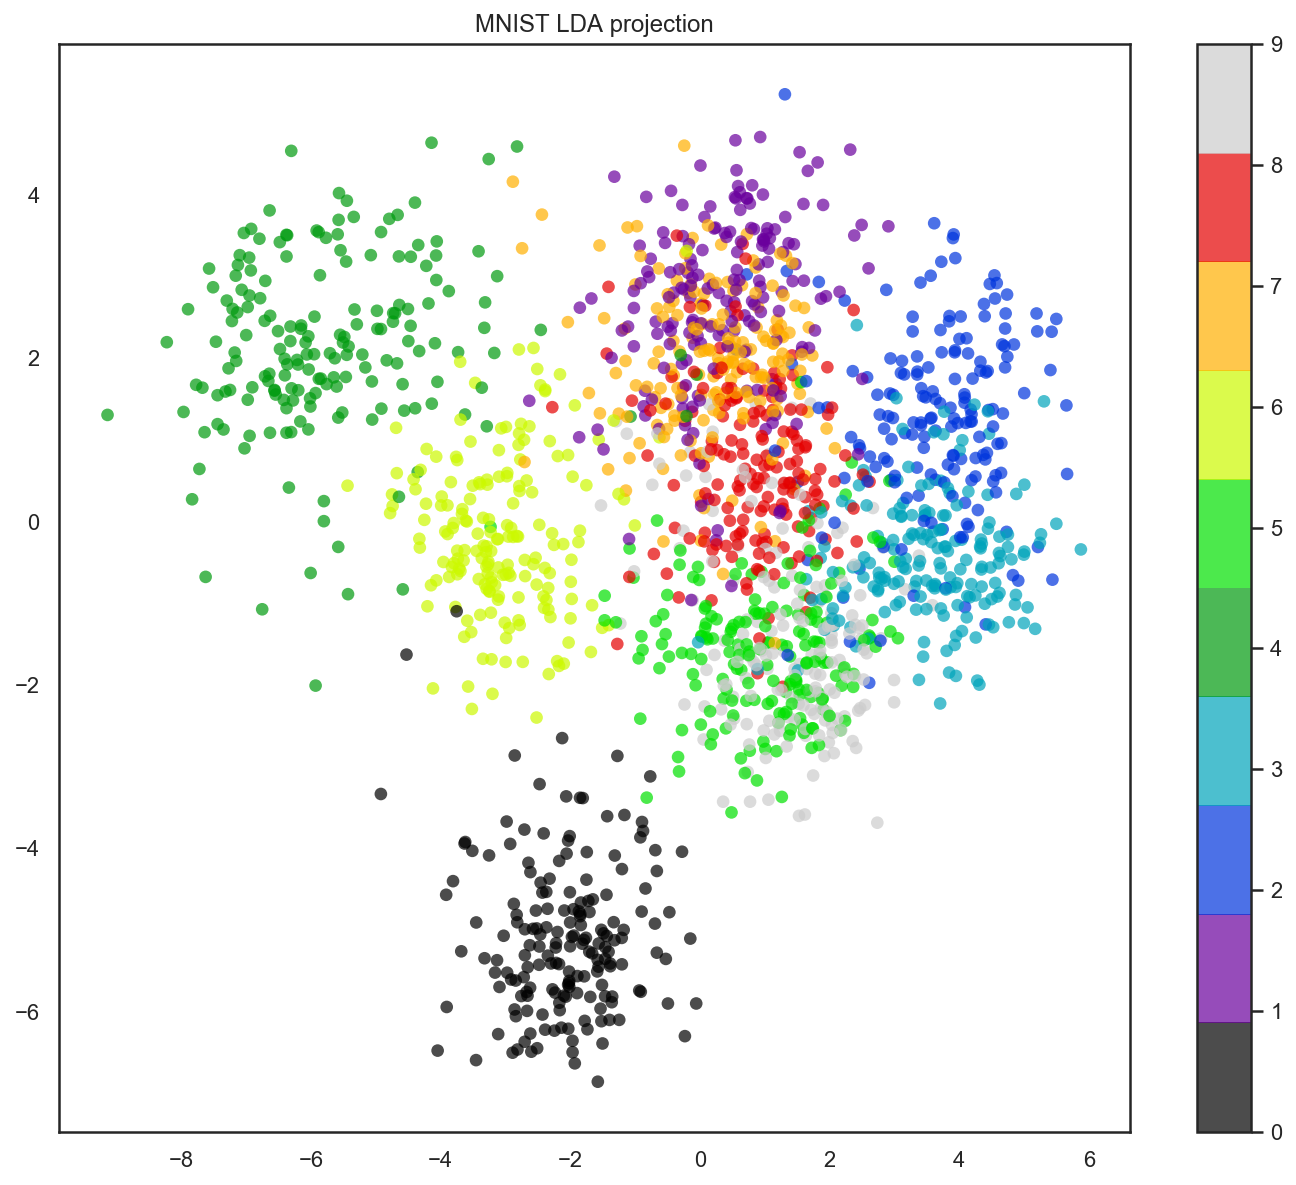

In [11]:
plt.figure(figsize=(12,10))
plt.scatter(X_LDA[:, 0], X_LDA[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST LDA projection');

# t-SNE

CPU times: user 46.8 s, sys: 964 ms, total: 47.8 s
Wall time: 3.46 s


Text(0.5, 1.0, 'MNIST. t-SNE projection')

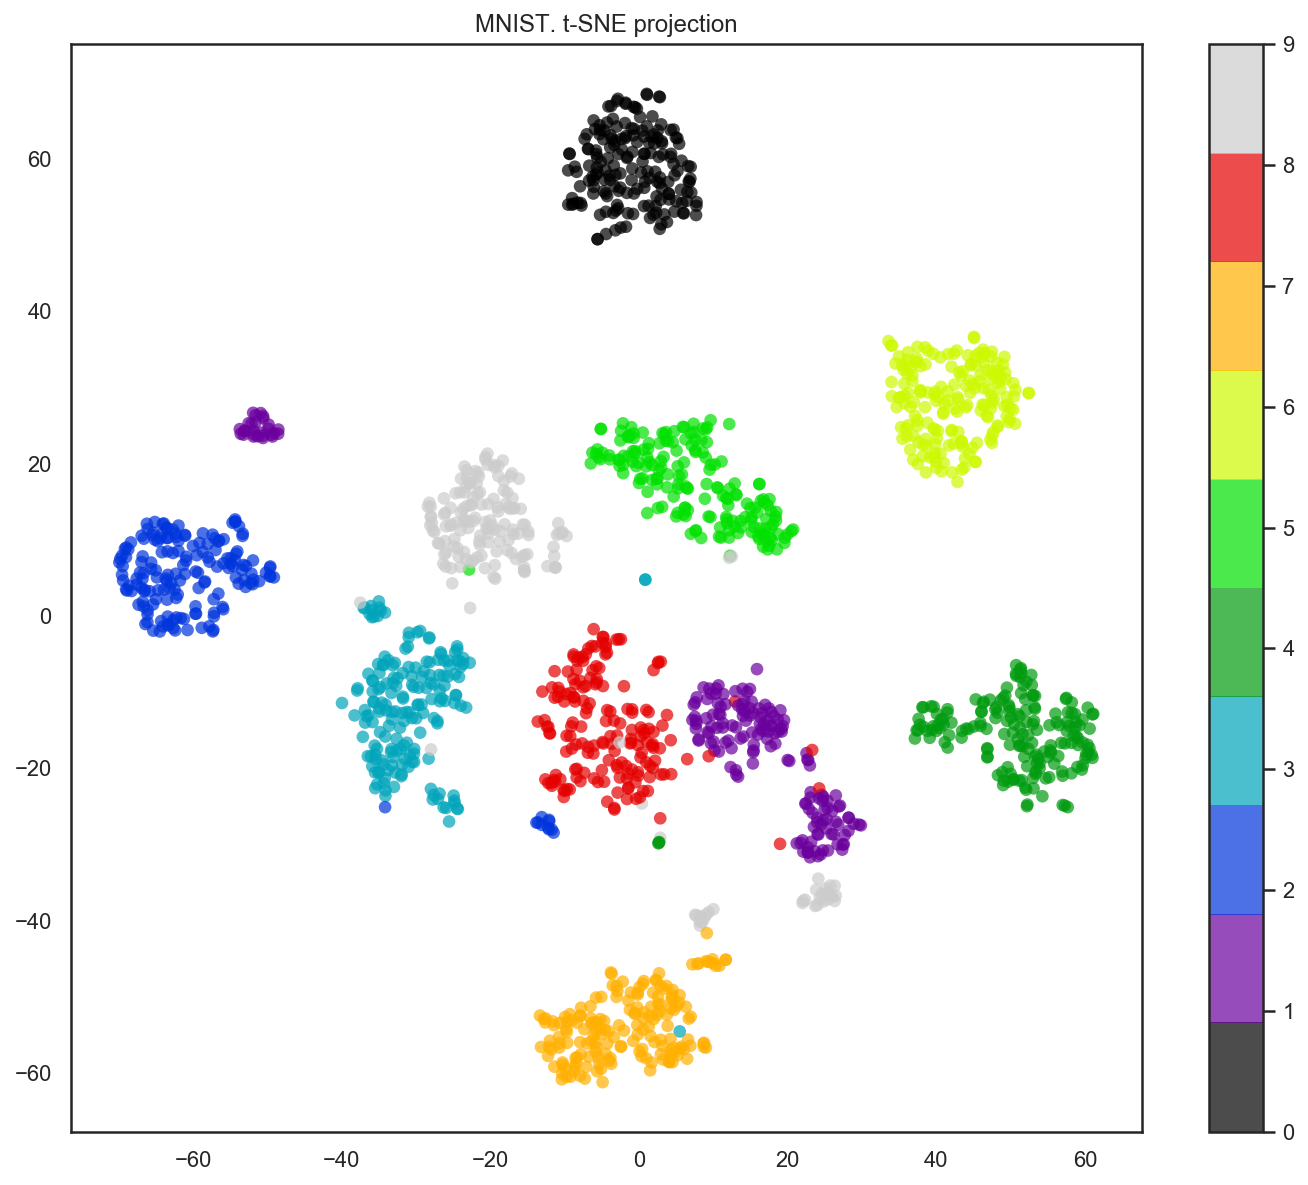

In [12]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

Indeed, with t-SNE, the picture looks better since PCA has a linear constraint while t-SNE does not. However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA.

# UMAP

In [16]:
#!pip install numba

In [17]:
#!pip install umap

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=c578e88e3b88d99aea810bb7b8ed5af98480ddf8f4c8f1f09a5216fffb2f3198
  Stored in directory: /Users/pavelgolubev/Library/Caches/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap


In [20]:
#!pip install umap-learn

     |████████████████████████████████| 68 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 565 kB 2.8 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.4.2-py3-none-any.whl size=66301 sha256=f3468b651e7db4574a8d22b07e99307d4bba7d1f3f89dc402c3dc51288a37828
  Stored in directory: /Users/pavelgolubev/Library/Caches/pip/wheels/53/ff/8a/1a6203990a3b86fb60240937bd9236f04951ad792cc27b896d
Successfully built umap-learn


In [23]:
import umap.umap_ as umap

In [24]:
%%time
reducer_mnist = umap.UMAP(random_state=42, n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation')
embedding = reducer_mnist.fit_transform(X)

CPU times: user 8.75 s, sys: 88 ms, total: 8.84 s
Wall time: 7.41 s


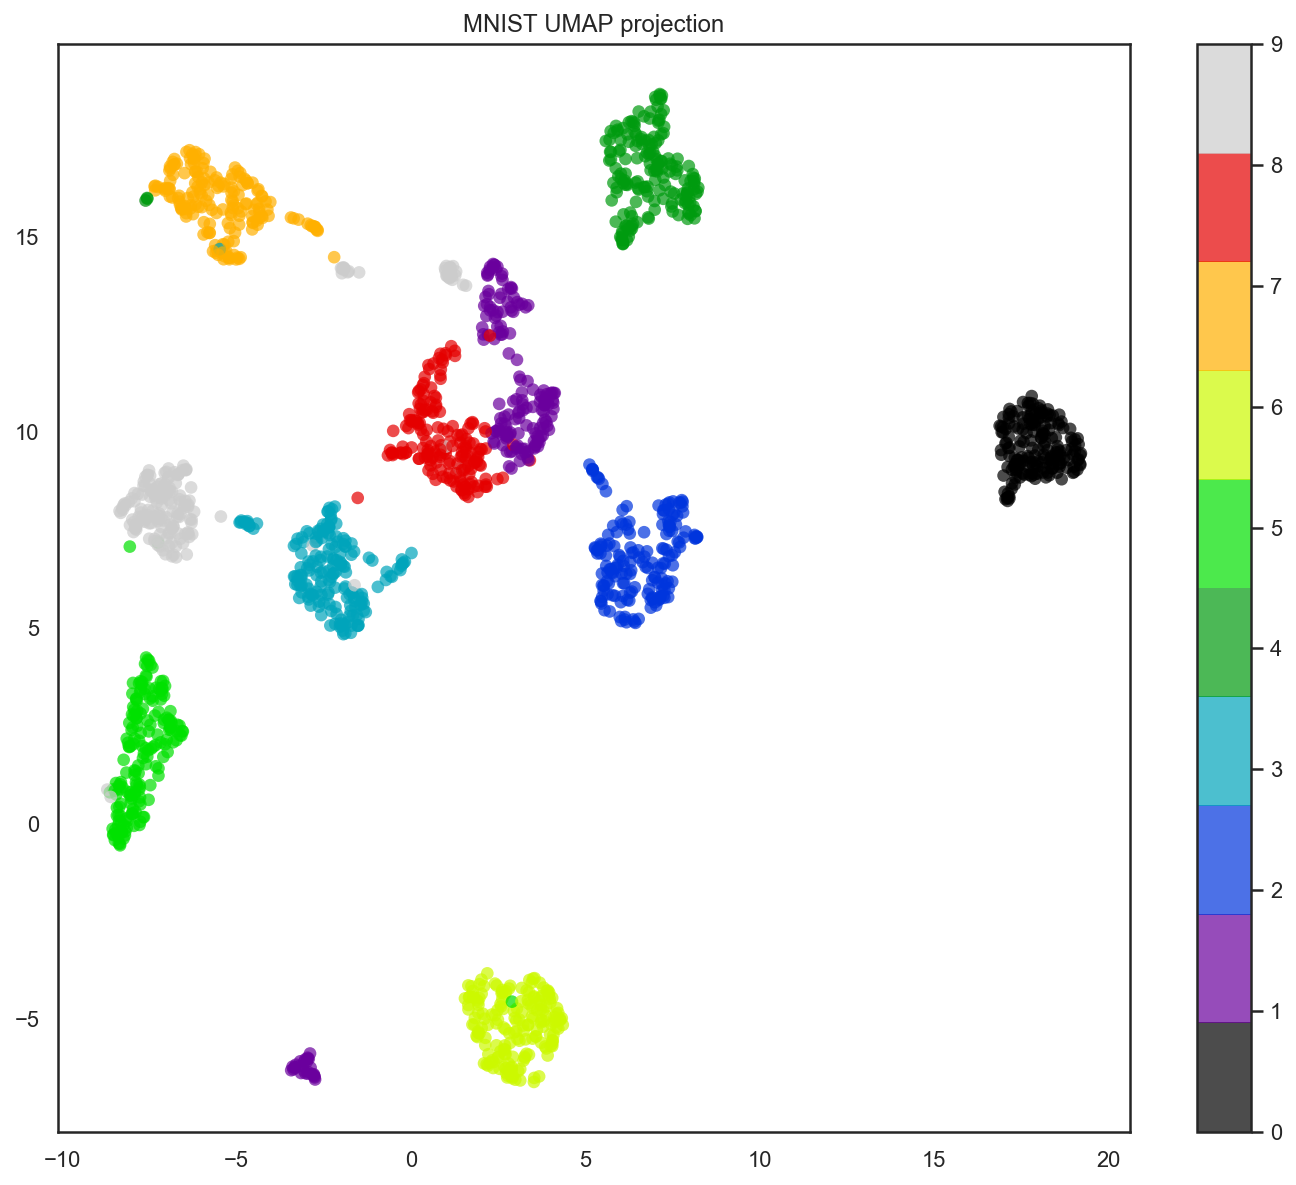

In [25]:
plt.figure(figsize=(12,10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST UMAP projection');

# UMAP - GOOD EXAMPLE

In [26]:
import pandas as pd

In [27]:
train = pd.read_csv("simplifiedhuarus/train.csv")
train.head(15)

,rn,activity,tBodyAcc.mean.X,tBodyAcc.mean.Y,tBodyAcc.mean.Z,tBodyAcc.std.X,tBodyAcc.std.Y,tBodyAcc.std.Z,tBodyAcc.mad.X,tBodyAcc.mad.Y,...,fBodyBodyGyroJerkMag.meanFreq,fBodyBodyGyroJerkMag.skewness,fBodyBodyGyroJerkMag.kurtosis,angle.tBodyAccMean.gravity,angle.tBodyAccJerkMean.gravityMean,angle.tBodyGyroMean.gravityMean,angle.tBodyGyroJerkMean.gravityMean,angle.X.gravityMean,angle.Y.gravityMean,angle.Z.gravityMean
0,7,STANDING,0.2790,-0.0196,-0.1100,-0.997,-0.967,-0.983,-0.997,-0.966,...,0.146,-0.217,-0.5640,-0.21300,-0.2310,0.01460,-0.19000,-0.852,0.1820,-0.0430
1,11,STANDING,0.2770,-0.0127,-0.1030,-0.995,-0.973,-0.985,-0.996,-0.974,...,0.121,0.349,0.0577,0.08070,0.5960,-0.47600,0.11600,-0.852,0.1880,-0.0347
2,14,STANDING,0.2770,-0.0147,-0.1070,-0.999,-0.991,-0.993,-0.999,-0.991,...,0.740,-0.564,-0.7660,0.10600,-0.0903,-0.13200,0.49900,-0.850,0.1890,-0.0351
3,15,STANDING,0.2980,0.0271,-0.0617,-0.989,-0.817,-0.902,-0.989,-0.794,...,0.131,0.208,-0.0681,0.06230,-0.0587,0.03120,-0.26900,-0.731,0.2830,0.0364
4,20,STANDING,0.2760,-0.0170,-0.1110,-0.998,-0.991,-0.998,-0.998,-0.989,...,0.667,-0.942,-0.9660,0.24500,0.1030,0.06610,-0.41200,-0.761,0.2630,0.0296
5,21,STANDING,0.2780,-0.0143,-0.1080,-0.998,-0.994,-0.996,-0.998,-0.994,...,0.601,-0.834,-0.9690,0.16100,0.1980,0.25800,-0.38100,-0.761,0.2630,0.0303
6,22,STANDING,0.2770,-0.0180,-0.1070,-0.998,-0.990,-0.997,-0.998,-0.990,...,0.576,-0.848,-0.9500,-0.00232,0.1500,0.14200,-0.85400,-0.762,0.2620,0.0300
7,24,STANDING,0.2790,-0.0177,-0.1090,-0.998,-0.987,-0.991,-0.999,-0.987,...,0.468,-0.910,-0.9870,-0.54300,-0.2500,0.00699,-0.23500,-0.759,0.2640,0.0305
8,31,SITTING,0.2220,0.0341,-0.1240,-0.815,-0.749,-0.572,-0.879,-0.777,...,-0.464,0.743,0.5970,0.17900,0.0776,0.05630,-0.31700,-0.583,-0.0208,-0.2550
9,32,SITTING,-0.0417,0.1750,0.0256,-0.758,-0.587,-0.439,-0.774,-0.555,...,-0.255,0.482,0.2560,0.11500,0.1140,-0.07080,-0.00146,-0.553,-0.0535,-0.2600


In [28]:
data = train.iloc[:, 2:].values.astype(np.float32)
target = train['activity'].values
activ = ["Walking", "Walking Upstairs", "Walking Downstairs", "Sitting", "Standing", "Laying"]
activities = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
pal = [
 'green',
 'red',
 'yellow',
 'grey',
 'brown',
 'black'
]
color_key = {activities[i]:pal[i] for i in range(len(pal))}

In [29]:
%%time
reducer = umap.UMAP(random_state=42, n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation')
embedding = reducer.fit_transform(data)

CPU times: user 19.8 s, sys: 131 ms, total: 19.9 s
Wall time: 17.2 s


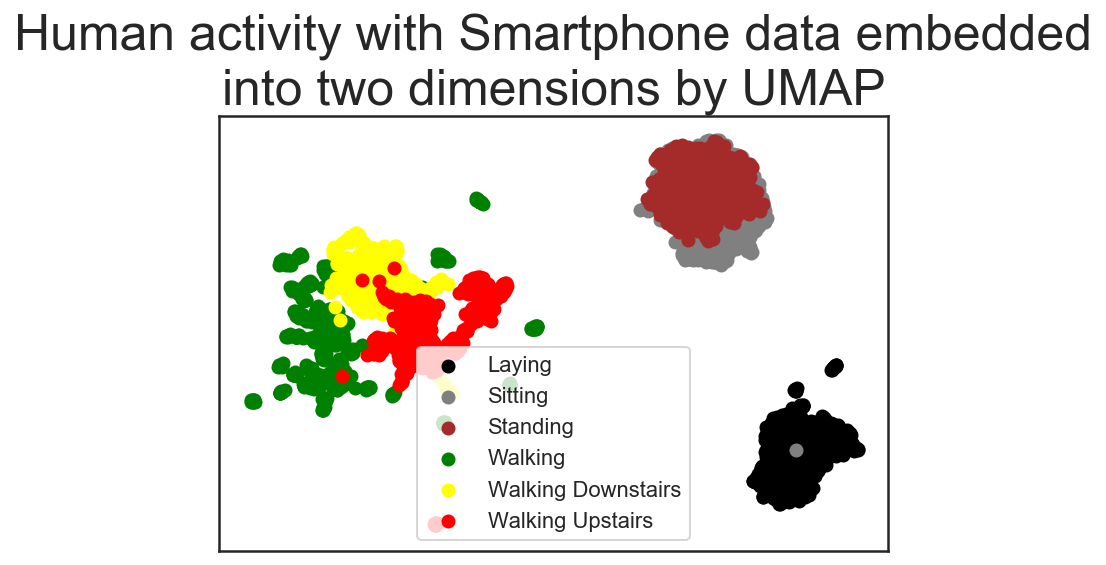

In [30]:
df = pd.DataFrame(embedding, columns=('x', 'y'))
df['class'] = pd.Series([str(x) for x in target], dtype="category")

fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('jet')

for i, cluster in df.groupby('class'):
    _ = ax.scatter(cluster['x'], cluster['y'], c=color_key[i], label=activ[activities.index(i)])
ax.legend()

plt.setp(ax, xticks=[], yticks=[])
plt.title("Human activity with Smartphone data embedded\n"
          "into two dimensions by UMAP",
          fontsize=25)

plt.show()

## 2. Clustering

The main idea behind clustering is pretty straightforward. Basically, we say to ourselves, "I have these points here, and I can see that they organize into groups. It would be nice to describe these things more concretely, and, when a new point comes in, assign it to the correct group." This general idea encourages exploration and opens up a variety of algorithms for clustering.

<figure><img align="center" src="https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png"><figcaption>*The examples of the outcomes from different algorithms from scikit-learn*</figcaption></figure>

The algorithms listed below do not cover all the clustering methods out there, but they are the most commonly used ones.

### K-means

K-means algorithm is the most popular and yet simplest of all the clustering algorithms. Here is how it works:
1. Select the number of clusters $k$ that you think is the optimal number.
2. Initialize $k$ points as "centroids" randomly within the space of our data.
3. Attribute each observation to its closest centroid.
4. Update the centroids to the center of all the attributed set of observations. 
5. Repeat steps 3 and 4 a fixed number of times or until all of the centroids are stable (i.e. no longer change in step 4).

This algorithm is easy to describe and visualize. Let's take a look.

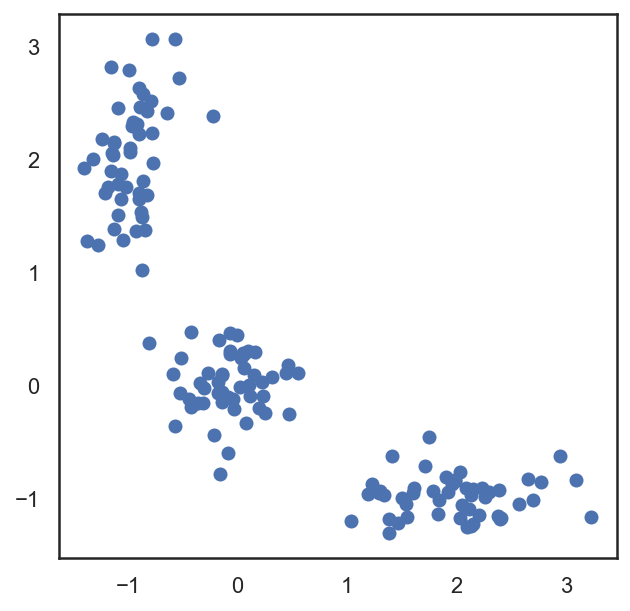

In [31]:
# Let's begin by allocation 3 cluster's points
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [32]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids 
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)
    
    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

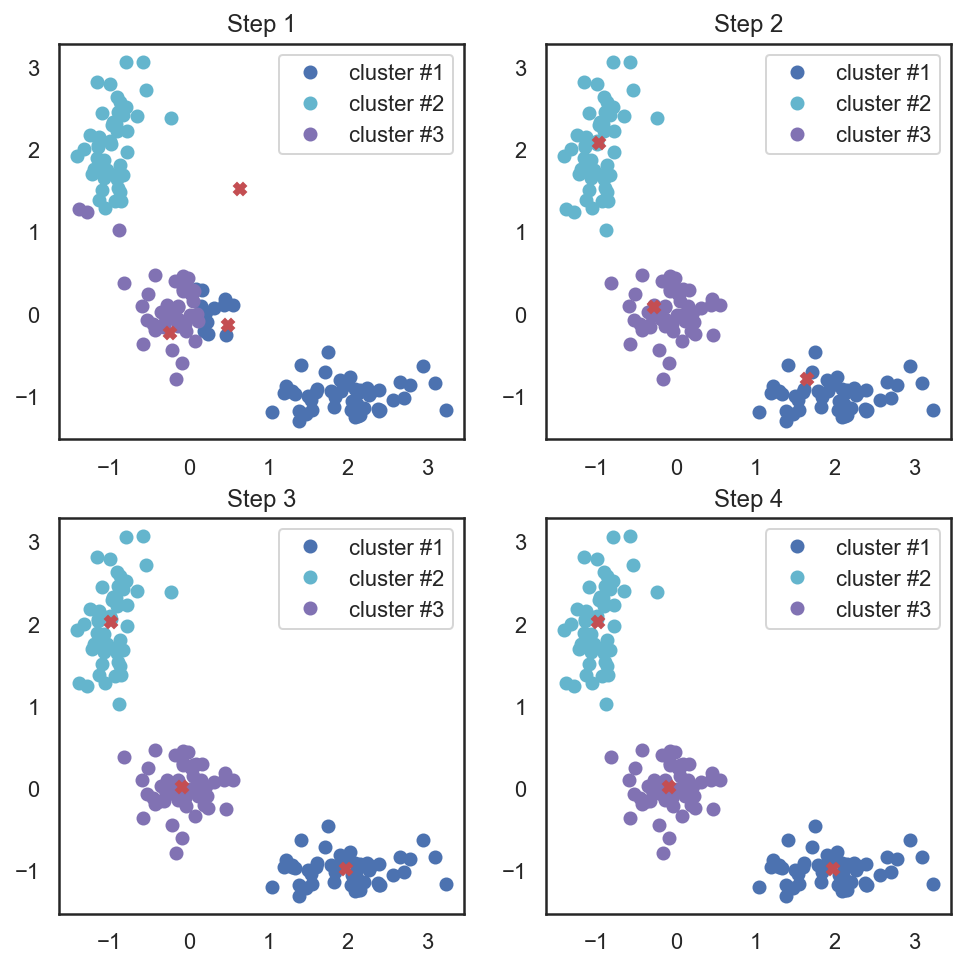

In [33]:
# Let's plot K-means
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Here, we used Euclidean distance, but the algorithm will converge with any other metric. You can not only vary the number of steps or the convergence criteria but also the distance measure between the points and cluster centroids.

Another "feature" of this algorithm is its sensitivity to the initial positions of the cluster centroids. You can run the algorithm several times and then average all the centroid results.

## Choosing the number of clusters for K-means

In contrast to the supervised learning tasks such as classification and regression, clustering requires more effort to choose the optimization criterion. Usually, when working with k-means, we optimize the sum of squared distances between the observations and their centroids.

$$\Large J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

where $C$ – is a set of clusters with power $K$, $\mu_k$ is a centroid of a cluster $C_k$.

This definition seems reasonable -- we want our observations to be as close to their centroids as possible. But, there is a problem -- the optimum is reached when the number of centroids is equal to the number of observations, so you would end up with every single observation as its own separate cluster.

In order to avoid that case, we should choose a number of clusters after which a function $J(C_k)$ is decreasing less rapidly. More formally,
$$\Large D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Let's look at an example.

In [34]:
from sklearn.cluster import KMeans

In [35]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))


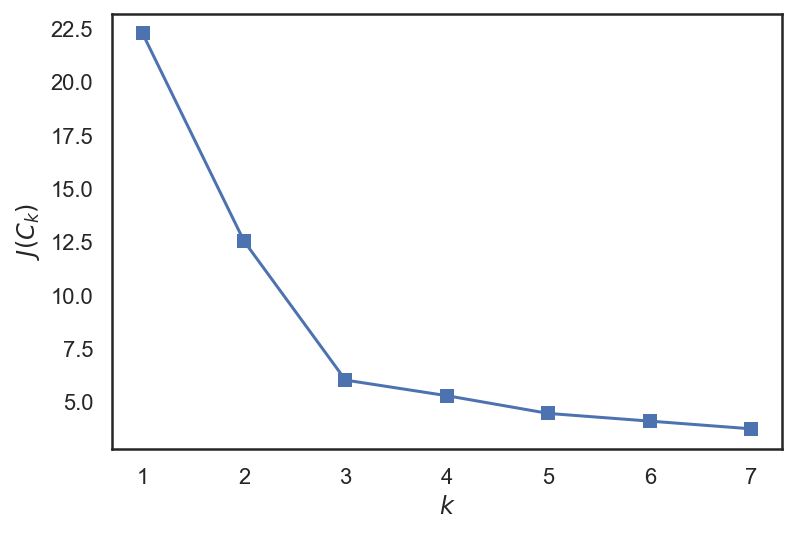

In [36]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

We see that $J(C_k)$ decreases significantly until the number of clusters is 3 and then does not change as much anymore. This means that the optimal number of clusters is 3. 

#### Issues

Inherently, K-means is NP-hard. For $d$ dimensions, $k$ clusters, and $n$ observations, we will find a solution in $O(n^{d k+1})$ in time. There are some heuristics to deal with this; an example is MiniBatch K-means, which takes portions (batches) of data instead of fitting the whole dataset and then moves centroids by taking the average of the previous steps. Compare the implementation of K-means and MiniBatch K-means in the [sckit-learn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).

The [implemetation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) of the algorithm using `scikit-learn` has its benefits such as the possibility to state the number of initializations with the `n_init` function parameter, which enables us to identify more robust centroids. Moreover, these runs can be done in parallel to decrease the computation time.

## Affinity Propagation

Affinity propagation is another example of a clustering algorithm. As opposed to K-means, this approach does not require us to set the number of clusters beforehand. The main idea here is that we would like to cluster our data based on the similarity of the observations (or how they "correspond" to each other).

Let's define a similarity metric such that $s(x_i, x_j) > s(x_i, x_k)$ if an observation $x_i$ is more similar to observation $x_j$ and less similar to observation $x_k$. A simple example of such a similarity metric is a negative square of distance $s(x_i, x_j) = - ||x_i - x_j||^{2}$.


Now, let's describe "correspondence" by making two zero matrices. One of them, $r_{i,k}$, determines how well the $k$th observation is as a "role model" for the $i$th observation with respect to all other possible "role models". Another matrix, $a_{i,k}$ determines how appropriate it would be for $i$th observation to take the $k$th observation as a "role model". This may sound confusing, but it becomes more understandable with some hands-on practice.

The matrices are updated sequentially with the following rules:

$$r_{i,k} \leftarrow s_(x_i, x_k) - \max_{k' \neq k} \left\{ a_{i,k'} + s(x_i, x_k') \right\}$$

$$a_{i,k} \leftarrow \min \left( 0, r_{k,k} + \sum_{i' \not\in \{i,k\}} \max(0, r_{i',k}) \right), \ \ \  i \neq k$$

$$a_{k,k} \leftarrow \sum_{i' \neq k} \max(0, r_{i',k})$$

## Spectral clustering

Spectral clustering combines some of the approaches described above to create a stronger clustering method.

First of all, this algorithm requires us to define the similarity matrix for observations called the adjacency matrix. This can be done in a similar fashion as in the Affinity Propagation algorithm: $A_{i, j} = - ||x_i - x_j||^{2}$. This matrix describes a full graph with the observations as vertices and the estimated similarity value between a pair of observations as edge weights for that pair of vertices. For the metric defined above and two-dimensional observations, this is pretty intuitive - two observations are similar if the edge between them is shorter. 
We'd like to split up the graph into two subgraphs in such a way that each observation in each subgraph would be similar to another observation in that subgraph. Formally, this is a Normalized cuts problem; for more details, we recommend reading [this paper](http://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf).

## Agglomerative clustering


The following algorithm is the simplest and easiest to understand among all the the clustering algorithms without a fixed number of clusters.


The algorithm is fairly simple:
1. We start by assigning each observation to its own cluster
2. Then sort the pairwise distances between the centers of clusters in descending order
3. Take the nearest two neigbor clusters and merge them together, and recompute the centers
4. Repeat steps 2 and 3 until all the data is merged into one cluster

The process of searching for the nearest cluster can be conducted with different methods of bounding the observations:
1. Single linkage 
$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
2. Complete linkage 
$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
3. Average linkage 
$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$
4. Centroid linkage 
$d(C_i, C_j) = ||\mu_i - \mu_j||$

The 3rd one is the most effective in computation time since it does not require recomputing the distances every time the clusters are merged.

The results can be visualized as a beautiful cluster tree (dendogram) to help recognize the moment the algorithm should be stopped to get optimal results. There are plenty of Python tools to build these dendograms for agglomerative clustering.

Let's consider an example with the clusters we got from K-means:

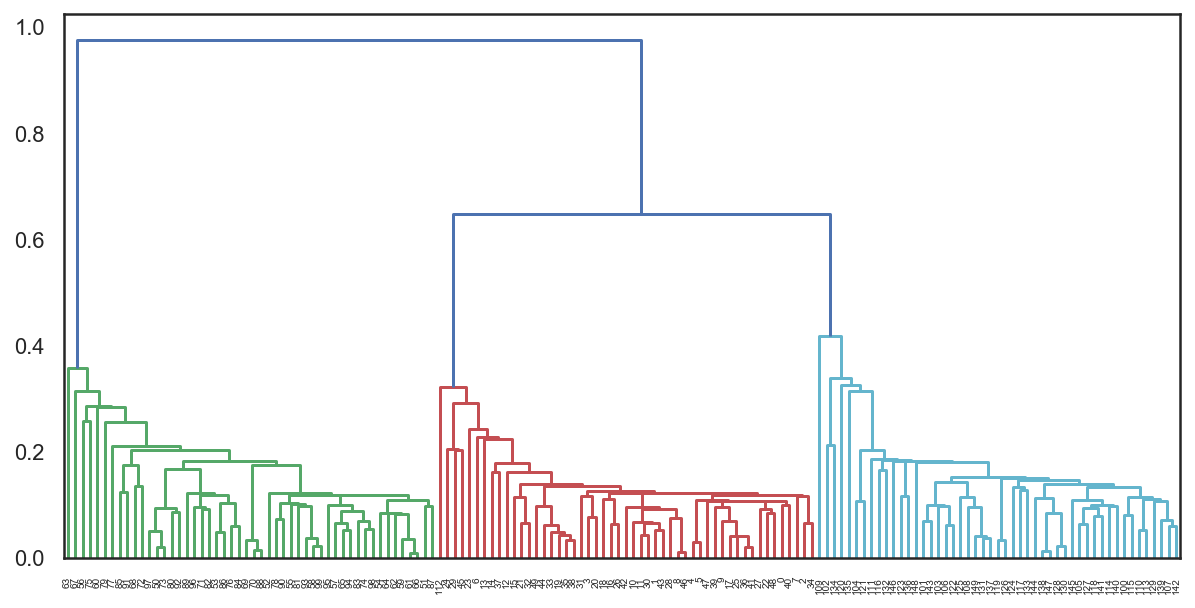

In [37]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

# pdist will calculate the upper triangle of the pairwise distance matrix
distance_mat = pdist(X) 
# linkage — is an implementation if agglomerative algorithm
Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

# DBSCAN

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [42]:
# Define a function to generate clusters
def cluster_gen(n_clusters, pts_minmax=(10, 100), x_mult=(1, 4), y_mult=(1, 3), 
                x_off=(0, 50), y_off=(0, 50)):
    
    # n_clusters = number of clusters to generate
    # pts_minmax = range of number of points per cluster 
    # x_mult = range of multiplier to modify the size of cluster in the x-direction
    # y_mult = range of multiplier to modify the size of cluster in the x-direction
    # x_off = range of cluster position offset in the x-direction
    # y_off = range of cluster position offset in the y-direction
    
    # Initialize some empty lists to receive cluster member positions
    clusters_x = []
    clusters_y = []
    # Genereate random values given parameter ranges
    n_points = np.random.randint(pts_minmax[0], pts_minmax[1], n_clusters)
    x_multipliers = np.random.randint(x_mult[0], x_mult[1], n_clusters)
    y_multipliers = np.random.randint(y_mult[0], y_mult[1], n_clusters)
    x_offsets = np.random.randint(x_off[0], x_off[1], n_clusters)
    y_offsets = np.random.randint(y_off[0], y_off[1], n_clusters)
     
    # Generate random clusters given parameter values
    for idx, npts in enumerate(n_points):
        
        xpts = np.random.randn(npts) * x_multipliers[idx] + x_offsets[idx]
        ypts = np.random.randn(npts) * y_multipliers[idx] + y_offsets[idx]
        clusters_x.append(xpts)
        clusters_y.append(ypts)
    
    # Return cluster positions
    return clusters_x, clusters_y

In [43]:
# Generate some clusters
n_clusters = 50
clusters_x, clusters_y = cluster_gen(n_clusters)
# Convert to a single dataset in OpenCV format
data = np.float32((np.concatenate(clusters_x), np.concatenate(clusters_y))).transpose()

In [44]:
# Define max_distance (eps parameter in DBSCAN())
max_distance = 1
db = DBSCAN(eps=max_distance, min_samples=10).fit(data)
# Extract a mask of core cluster members
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Extract labels (-1 is used for outliers)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)


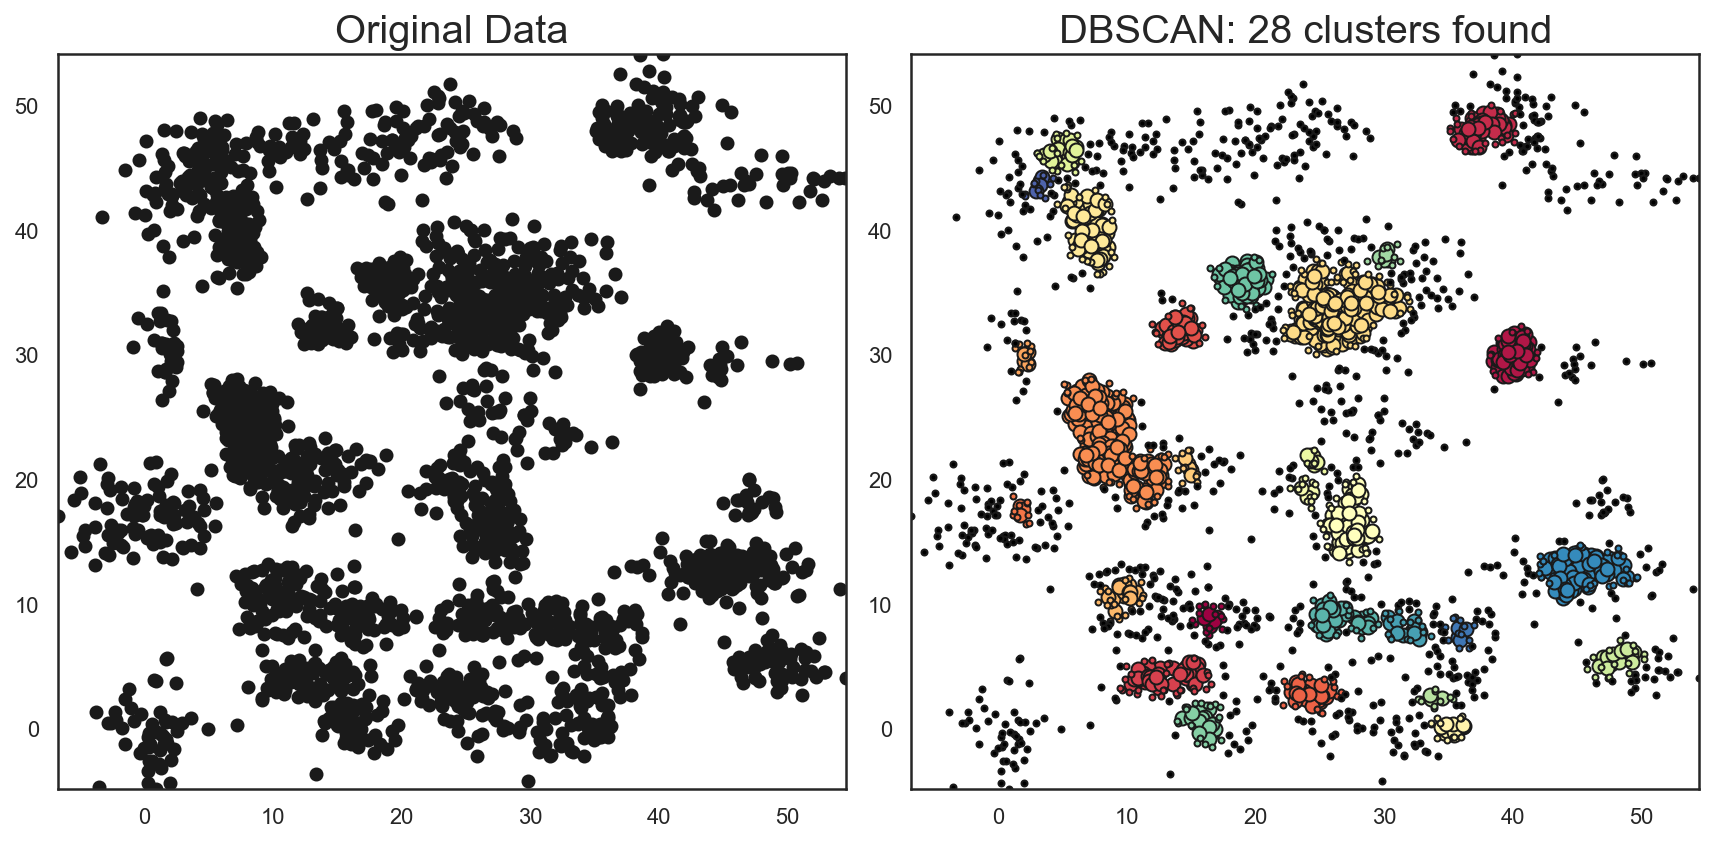

In [45]:
# Plot up the results
min_x = np.min(data[:, 0])
max_x = np.max(data[:, 0])
min_y = np.min(data[:, 1])
max_y = np.max(data[:, 1])

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(data[:,0], data[:,1], 'ko')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('Original Data', fontsize = 20)

plt.subplot(122)
# The following is just a fancy way of plotting core, edge and outliers
# Credit to: http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('DBSCAN: %d clusters found' % n_clusters, fontsize = 20)
fig.tight_layout()
plt.subplots_adjust(left=0.03, right=0.98, top=0.9, bottom=0.05)

## Accuracy metrics

As opposed to classfication, it is difficult to assess the quality of results from clustering. Here, a metric cannot depend on the labels but only on the goodness of split. Secondly, we do not usually have true labels of the observations when we use clustering.

There are *internal* and *external* goodness metrics. External metrics use the information about the known true split while internal metrics do not use any external information and assess the goodness of clusters based only on the initial data. The optimal number of clusters is usually defined with respect to some internal metrics. 

All the metrics described below are implemented in `sklearn.metrics`.

**Adjusted Rand Index (ARI)**

Here, we assume that the true labels of objects are known. This metric does not depend on the labels' values but on the data cluster split. Let $N$ be the number of observations in a sample. Let $a$ to be the number of observation pairs with the same labels and located in the same cluster, and let $b$ to be the number of observations with different labels and located in different clusters. The Rand Index can be calculated using the following formula: 

$$\Large \text{RI} = \frac{2(a + b)}{n(n-1)}.$$ 

In other words, it evaluates a share of observations for which these splits (initial and clustering result) are consistent. The Rand Index (RI) evaluates the similarity of the two splits of the same sample. In order for this index to be close to zero for any clustering outcomes with any $n$ and number of clusters, it is essential to scale it, hence the Adjusted Rand Index: 

$$\Large \text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

This metric is symmetric and does not depend in the label permutation. Therefore, this index is a measure of distances between different sample splits. $\text{ARI}$ takes on values in the $[-1, 1]$ range. Negative values indicate the independence of splits, and positive values indicate that these splits are consistent (they match $\text{ARI} = 1$).

**Adjusted Mutual Information (AMI)**

This metric is similar to $\text{ARI}$. It is also symmetric and does not depend on the labels' values and permutation. It is defined by the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) function and interprets a sample split as a discrete distribution (likelihood of assigning to a cluster is equal to the percent of objects in it). The $MI$ index is defined as the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) for two distributions, corresponding to the sample split into clusters. Intuitively, the mutual information measures the share of information common for both clustering splits i.e. how information about one of them decreases the uncertainty of the other one.

Similarly to the $\text{ARI}$, the $\text{AMI}$ is defined. This allows us to get rid of the $MI$ index's increase with the number of clusters. The $\text{AMI}$ lies in the $[0, 1]$ range. Values close to zero mean the splits are independent, and those close to 1 mean they are similar (with complete match at $\text{AMI} = 1$).

**Homogeneity, completeness, V-measure**

Formally, these metrics are also defined based on the entropy function and the conditional entropy function, interpreting the sample splits as discrete distributions: 

$$\Large h = 1 - \frac{H(C\mid K)}{H(C)}, c = 1 - \frac{H(K\mid C)}{H(K)},$$

where $K$ is a clustering result and $C$ is the initial split. Therefore, $h$ evaluates whether each cluster is composed of same class objects, and $c$ measures how well the same class objects fit the clusters. These metrics are not symmetric. Both lie in the $[0, 1]$ range, and values closer to 1 indicate more accurate clustering results. These metrics' values are not scaled as the $\text{ARI}$ or $\text{AMI}$ metrics are and thus depend on the number of clusters. A random clustering result will not have metrics' values closer to zero when the number of clusters is big enough and the number of objects is small. In such a case, it would be more reasonable to use $\text{ARI}$. However, with a large number of observations (more than 100) and the number of clusters less than 10, this issue is less critical and can be ignored.

$V$-measure is a combination of $h$, and $c$ and is their harmonic mean:
$$\Large v = 2\frac{hc}{h+c}.$$
It is symmetric and measures how consistent two clustering results are.

**Silhouette**

In contrast to the metrics described above, this coefficient does not imply the knowledge about the true labels of the objects. It lets us estimate the quality of the clustering using only the initial, unlabeled sample and the clustering result. To start with, for each observation, the silhouette coefficient is computed. Let $a$ be the mean of the distance between an object and other objects within one cluster and $b$ be the mean distance from an object to an object from the nearest cluster (different from the one the object belongs to). Then the silhouette measure for this object is 

$$\Large s = \frac{b - a}{\max(a, b)}.$$

The silhouette of a sample is a mean value of silhouette values from this sample. Therefore, the silhouette distance shows to which extent the distance between the objects of the same class differ from the mean distance between the objects from different clusters. This coefficient takes values in the $[-1, 1]$ range. Values close to -1 correspond to bad clustering results while values closer to 1 correspond to dense, well-defined clusters. Therefore, the higher the silhouette value is, the better the results from clustering.

With the help of silhouette, we can identify the optimal number of clusters $k$ (if we don't know it already from the data) by taking the number of clusters that maximizes the silhouette coefficient.

To conclude, let's take a look at how these metrics perform with the MNIST handwritten numbers dataset:

In [46]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering


data = datasets.load_digits()
X, y = data.data, data.target

algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_,
                                                 average_method='arithmetic'),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.668587,0.741156,0.739464,0.748061,0.743737,0.182524
Affinity,0.175174,0.612460,0.958907,0.486901,0.645857,0.115197
Spectral,0.756461,0.852040,0.831691,0.876614,0.853562,0.182729
Agglomerative,0.794003,0.866832,0.857513,0.879096,0.868170,0.178497


## 5. Useful resources
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-7-unsupervised-learning-pca-and-clustering-db7879568417) based on this notebook
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- Overview of clustering methods in the [scikit-learn doc](http://scikit-learn.org/stable/modules/clustering.html).
- [Q&A](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) for PCA with examples
- [Notebook](https://github.com/diefimov/MTH594_MachineLearning/blob/master/ipython/Lecture10.ipynb) on k-means and the EM-algorithm